In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from carbo import*

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler, OneHotEncoder,MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn import preprocessing
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV


In [2]:
df = pd.read_csv('car_sales.csv')
df.drop(columns = ['Unnamed: 0'],inplace = True)

In [3]:
df.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,car_brand
0,A1,2017,12500,Manual,15735,Petrol,150,55.4,1.4,audi
1,A6,2016,16500,Automatic,36203,Diesel,20,64.2,2.0,audi
2,A1,2016,11000,Manual,29946,Petrol,30,55.4,1.4,audi
3,A4,2017,16800,Automatic,25952,Diesel,145,67.3,2.0,audi
4,A3,2019,17300,Manual,1998,Petrol,145,49.6,1.0,audi


In [4]:
df.dtypes

model            object
year              int64
price             int64
transmission     object
mileage           int64
fuelType         object
tax               int64
mpg             float64
engineSize      float64
car_brand        object
dtype: object

In [5]:
# Let's take the numerical variabels of the dataset
df_num_aux = df.drop(columns = ['model', 'transmission','fuelType','car_brand'])

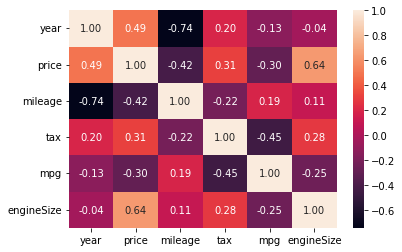

In [6]:
#Let's take a look to the correlation matrix, since we want to predict the price, this is what we get
sns.heatmap(df_num_aux.corr(), annot=True, fmt=".2f");

In [7]:
#Now, let's take the numeric and categorical variables
# It's important to drop the 'price' column, since it's the feature we want to predict
num_df = df.drop(columns = ['model','transmission','fuelType','car_brand','price']) 


Since we have to dummify all the categorical variables, we have to keep an eye on model complexity.

In [8]:
len(df['transmission'].unique())

4

In [9]:
len(df['fuelType'].unique())

5

In [10]:
len(df['car_brand'].unique())

9

In [11]:
len(df['model'].unique())

195

I'm going to take into consideration all categorical variables except `car model`, since, it will increase model complexity al lot, and also, there are models of car not seen on this data set, so this way we can fit a model that works on more situations.

In [12]:
cat_df = df[['transmission','fuelType','car_brand']]

In [13]:
num_df.head(1)

,year,mileage,tax,mpg,engineSize
0,2017,15735,150,55.4,1.4


In [14]:
cat_df.head(1)

,transmission,fuelType,car_brand
0,Manual,Petrol,audi


In [15]:
cat_df_dum = create_dummy_df(cat_df, cat_df.columns, dummy_na = False)

### Find the optimal model:

A car value it's dependent on various features, as we saw in the corr. matrix. For example, the bigger the mileage of the car, the lower the price ( not always ), as well as the bigger the engine size of the car, the higher the price. This is beacuse higher engine sizes are related to more luxury cars. With all this features combined, I'm going to do my best to find a model that is able to predict the price of a car based on it's features:

To fit the best possible model, this is my way to go:

- **1** : Find a linear regression model using all the variables, except, `car_model`, and evaluate it
- **2**: Use GridSearch to find the optimal parameters
- **3**: Fit a linear regression model, usial all the varibales, `car_model`, and see if it's worth it to have a way more complex model
- **4**: Try and fit another model
- **5**: Using GridSearch, get the best parameters for that model

The models are going to be evaluated using the .score metric from scikit learn. This is the metric scikit learn uses to compare different combinations of hyperparameters in GridSearch.

For linearRegression, I'm also using the r2squared.

### **1**: linear regression model using all the variables, except, car_model, and evaluate it

In [16]:
X = pd.concat([num_df,cat_df_dum],axis = 1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=0)

In [17]:
#  I choose degree 0 as a random number, the optimal degree value will be found thaks to GridSearch


poly = PolynomialFeatures(degree = 1) # I choose degree 0 as a random number, the optimal degree value will be found thaks to GridSearch
regress = LinearRegression()

pipe = Pipeline( steps = [('poly',poly),
                                 ('regress',regress)]
)
    
pipe.fit(X_train, y_train)

Pipeline(steps=[('poly', PolynomialFeatures(degree=1)),
                ('regress', LinearRegression())])

In [18]:
y_test_preds = pipe.predict(X_test) 
y_train_preds = pipe.predict(X_train)
test_score = r2_score(y_test, y_test_preds)
train_score = r2_score(y_train, y_train_preds)

In [19]:
pipe.score(X_test, y_test)

0.776328703156393

In [20]:
print("The rsquared on the training data was {}.  The rsquared on the test data was {}.".format(train_score, test_score))


The rsquared on the training data was 0.7620552415382266.  The rsquared on the test data was 0.776328703156393.


### **2**: Use GridSearch to find the optimal parameters

In [21]:
parameters = pipe.get_params()
parameters

{'memory': None,
 'steps': [('poly', PolynomialFeatures(degree=1)),
  ('regress', LinearRegression())],
 'verbose': False,
 'poly': PolynomialFeatures(degree=1),
 'regress': LinearRegression(),
 'poly__degree': 1,
 'poly__include_bias': True,
 'poly__interaction_only': False,
 'poly__order': 'C',
 'regress__copy_X': True,
 'regress__fit_intercept': True,
 'regress__n_jobs': None,
 'regress__normalize': 'deprecated',
 'regress__positive': False}

In [22]:
param_grid = {
    'poly__degree': [1,2,3]
}

In [23]:
cv = GridSearchCV(pipe, param_grid, scoring = 'explained_variance')

In [24]:
cv.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('poly', PolynomialFeatures(degree=1)),
                                       ('regress', LinearRegression())]),
             param_grid={'poly__degree': [1, 2, 3]},
             scoring='explained_variance')

In [25]:
df_gridsearch = pd.DataFrame(cv.cv_results_)
df_gridsearch.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_poly__degree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.068391,0.001194,0.005023,0.000629,1,{'poly__degree': 1},0.756378,0.761383,0.757968,0.763194,0.768476,0.761480,0.004249,2
1,1.091800,0.009282,0.048601,0.005954,2,{'poly__degree': 2},0.869044,0.866269,0.830778,0.863488,0.869610,0.859838,0.014693,1
2,15.399975,0.350375,0.270231,0.002925,3,{'poly__degree': 3},0.886797,0.266477,0.683592,0.521676,0.767964,0.625301,0.215232,3


In [26]:
rank = df_gridsearch[['params','rank_test_score']]
rank

,params,rank_test_score
0,{'poly__degree': 1},2
1,{'poly__degree': 2},1
2,{'poly__degree': 3},3


Based on this information, I fit a model with the best possible hyperparameters.

In [27]:
poly = PolynomialFeatures(degree = 2)
regress = LinearRegression()


pipe = Pipeline( steps = [('poly',poly),
                                 ('regress',regress)]
)
    
pipe.fit(X_train, y_train)

Pipeline(steps=[('poly', PolynomialFeatures()),
                ('regress', LinearRegression())])

In [28]:
y_test_preds = pipe.predict(X_test) 
y_train_preds = pipe.predict(X_train)
test_score = r2_score(y_test, y_test_preds)
train_score = r2_score(y_train, y_train_preds)

print("The rsquared on the training data was {}.  The rsquared on the test data was {}.".format(train_score, test_score))



The rsquared on the training data was 0.872101375557497.  The rsquared on the test data was 0.8751923589429387.


### **3**: Fit a linear regression model, usial all the varibales, `car_model`, and see if it's worth it to have a way more complex model

In [29]:
num_df = df.drop(columns = ['model','transmission','fuelType','car_brand','price']) 
cat_df = df[['model','car_brand','transmission','fuelType']]
cat_df_dum = create_dummy_df(cat_df, cat_df.columns, dummy_na = False)

In [30]:
X = pd.concat([num_df,cat_df_dum],axis = 1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=0)

PolynomialFeatures(degree = 1) because more is impossible to handle, an error will pop up

In [31]:
poly = PolynomialFeatures(degree = 1)
regress = LinearRegression()


pipe = Pipeline( steps = [('poly',poly),
                                 ('regress',regress)]
)
    
pipe.fit(X_train, y_train)

Pipeline(steps=[('poly', PolynomialFeatures(degree=1)),
                ('regress', LinearRegression())])

In [32]:
pipe.score(X_test, y_test)

0.8579914350248397

In [33]:
y_test_preds = pipe.predict(X_test) 
y_train_preds = pipe.predict(X_train)
test_score = r2_score(y_test, y_test_preds)
train_score = r2_score(y_train, y_train_preds)

### **4**: Try and fit another model
In this case: KNeighbors Regressor

In [34]:
# In this case, we are not using 'car_model'
num_df = df.drop(columns = ['model','transmission','fuelType','car_brand','price']) 
cat_df = df[['transmission','fuelType']]
cat_df_dum = create_dummy_df(cat_df, cat_df.columns, dummy_na = False)

In [35]:
X = pd.concat([num_df,cat_df_dum],axis = 1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=0)

For the first fit, I choose to make the decission on the price, based on the 2 closest neighbors. The optimal value of this hyperparameter, will be found later!

In [36]:
regr = KNeighborsRegressor(2)
regr.fit(X_train,y_train)

KNeighborsRegressor(n_neighbors=2)

In [37]:
regr.fit(X_train,y_train)
regr.score(X_test, y_test)

0.3665356581287226

### **5**: Using GridSearch, get the best parameters for that model

In [38]:
# I choose to evaluate the model performance for the first 10 neighbors
param_grid = {
    'n_neighbors': [1,2,3,4,5,6,7,8,9,10]
}

In [39]:
parameters = regr.get_params()
parameters

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 2,
 'p': 2,
 'weights': 'uniform'}

In [40]:
cv = GridSearchCV(regr, param_grid, scoring = 'explained_variance')

In [41]:
cv.fit(X_train,y_train)

GridSearchCV(estimator=KNeighborsRegressor(n_neighbors=2),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
             scoring='explained_variance')

In [42]:
df_gridsearch = pd.DataFrame(cv.cv_results_)
df_gridsearch

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.231997,0.005899,0.111610,0.004759,1,{'n_neighbors': 1},0.188557,0.233063,0.207902,0.206587,0.160505,0.199323,0.024031,10
1,0.236414,0.002076,0.119996,0.002751,2,{'n_neighbors': 2},0.337307,0.369118,0.361030,0.362326,0.336021,0.353160,0.013753,9
2,0.236816,0.001922,0.127797,0.003305,3,{'n_neighbors': 3},0.391513,0.410767,0.411903,0.409637,0.386154,0.401995,0.010902,8
3,0.238234,0.004069,0.134987,0.001796,4,{'n_neighbors': 4},0.412117,0.423749,0.431888,0.425783,0.411726,0.421053,0.007923,7
4,0.235226,0.004031,0.135806,0.002026,5,{'n_neighbors': 5},0.419955,0.429809,0.439089,0.432728,0.419576,0.428231,0.007537,6
5,0.235609,0.001379,0.141400,0.002577,6,{'n_neighbors': 6},0.429103,0.434561,0.443665,0.435696,0.425187,0.433642,0.006287,5
6,0.237826,0.001728,0.147993,0.003224,7,{'n_neighbors': 7},0.428879,0.440373,0.443673,0.437359,0.425641,0.435185,0.006849,4
7,0.234232,0.001722,0.147594,0.004132,8,{'n_neighbors': 8},0.431279,0.440530,0.444367,0.441194,0.429538,0.437382,0.005865,1
8,0.236828,0.002397,0.151787,0.003129,9,{'n_neighbors': 9},0.428835,0.440692,0.444814,0.440264,0.430050,0.436931,0.006329,2
9,0.233825,0.001332,0.155190,0.002641,10,{'n_neighbors': 10},0.427797,0.437021,0.444208,0.438786,0.430917,0.435746,0.005813,3


In [43]:
rank = df_gridsearch[['params','rank_test_score']]
rank

,params,rank_test_score
0,{'n_neighbors': 1},10
1,{'n_neighbors': 2},9
2,{'n_neighbors': 3},8
3,{'n_neighbors': 4},7
4,{'n_neighbors': 5},6
5,{'n_neighbors': 6},5
6,{'n_neighbors': 7},4
7,{'n_neighbors': 8},1
8,{'n_neighbors': 9},2
9,{'n_neighbors': 10},3


In [44]:
regr = KNeighborsRegressor(8)
regr.fit(X_train,y_train)
regr.score(X_test, y_test)

0.44954216273884084